# Modelo de K-Means para la segmentación de clientes

## Importación de librerías

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.spatial import distance_matrix

## Importación del data-set

In [ ]:
# Cargar el dataset desde el archivo subido
df = pd.read_csv('online_retail-1.csv', encoding='latin1')

## Limpieza del data-set y creación de nuevas variables

In [ ]:
# --- Limpieza de Datos ---

# 1. Eliminar filas sin Customer ID, ya que son esenciales para el análisis
df.dropna(axis=0, subset=['Customer ID'], inplace=True)

# 2. Convertir Customer ID a tipo entero para consistencia
df['Customer ID'] = df['Customer ID'].astype(int)

# 3. Eliminar cantidades negativas (probables devoluciones)
df = df[df['Quantity'] > 0]

# 4. Crear la columna 'Revenue' (Gasto por transacción)
df['Revenue'] = df['Quantity'] * df['Price']

print("Datos después de la limpieza inicial:")
print(df.head())

Datos después de la limpieza inicial:
  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

    InvoiceDate  Price  Customer ID         Country  Revenue  
0  12/1/09 7:45   6.95        13085  United Kingdom     83.4  
1  12/1/09 7:45   6.75        13085  United Kingdom     81.0  
2  12/1/09 7:45   6.75        13085  United Kingdom     81.0  
3  12/1/09 7:45   2.10        13085  United Kingdom    100.8  
4  12/1/09 7:45   1.25        13085  United Kingdom     30.0  


## Ingeniería de características (Creación del data-set final)

In [ ]:
# --- Ingeniería de Características ---

# Agrupar por cliente y calcular el gasto total y la frecuencia
customer_df = df.groupby('Customer ID').agg({
    'Revenue': 'sum',          # Gasto Total: Suma del Revenue
    'Invoice': 'nunique'       # Frecuencia: Conteo de facturas únicas
}).rename(columns={'Invoice': 'Frequency'})

print("\nDataset agregado por cliente:")
print(customer_df.head())


Dataset agregado por cliente:
             Revenue  Frequency
Customer ID                    
12346         372.86         11
12349        1268.52          2
12355         488.21          1
12358        1697.93          2
12359        2012.03          5


## Visualización de la distribución de las variables generadas

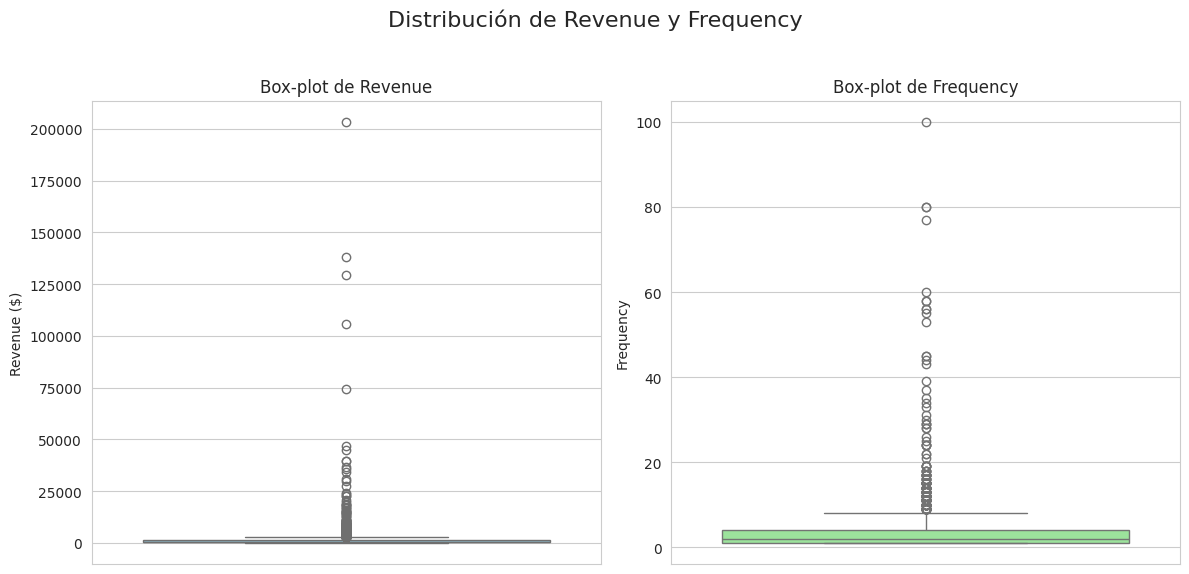

In [ ]:
# --- Box Plot de Variables Generadas ---

# Configurar el estilo de las gráficas
sns.set_style("whitegrid")

# Crear una figura con dos subplots (uno al lado del otro)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Título general para ambas gráficas
fig.suptitle('Distribución de Revenue y Frequency', fontsize=16)

# Generar el box-plot para 'Revenue' en el primer subplot
sns.boxplot(ax=axes[0], y=customer_df['Revenue'], color='skyblue')
axes[0].set_title('Box-plot de Revenue')
axes[0].set_ylabel('Revenue ($)')

# Generar el box-plot para 'Frequency' en el segundo subplot
sns.boxplot(ax=axes[1], y=customer_df['Frequency'], color='lightgreen')
axes[1].set_title('Box-plot de Frequency')
axes[1].set_ylabel('Frequency')

# Ajustar el layout y mostrar las gráficas
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Manejo de outliers y estandarización

In [ ]:
# --- Manejo de Outliers ---
# Eliminaremos los valores en el 1% superior para evitar que sesguen el modelo
high_revenue_threshold = customer_df['Revenue'].quantile(0.99)
high_freq_threshold = customer_df['Frequency'].quantile(0.99)

customer_df_clean = customer_df[(customer_df['Revenue'] < high_revenue_threshold) &
                                (customer_df['Frequency'] < high_freq_threshold)]

# --- Estandarización de Datos ---
# Seleccionamos solo las columnas para el clustering
features = customer_df_clean[['Revenue', 'Frequency']]

# Creamos una instancia del estandarizador
scaler = StandardScaler()

# Ajustamos y transformamos los datos
features_scaled = scaler.fit_transform(features)

# Convertimos el resultado de nuevo a un DataFrame para mayor claridad
features_scaled_df = pd.DataFrame(features_scaled, columns=['Revenue', 'Frequency'])

print("\nPrimeras 5 filas de datos estandarizados:")
print(features_scaled_df.head())

## Método del Codo para encontrar K

In [ ]:
# --- Método del Codo para encontrar K óptimo ---

inertia = []
K_range = range(1, 11) # Probaremos con k desde 1 hasta 10

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10) # n_init='auto' o 10
    kmeans.fit(features_scaled_df)
    inertia.append(kmeans.inertia_)

# Graficar los resultados
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertia, marker='o', linestyle='--')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inercia (WCSS)')
plt.title('Método del Codo para Encontrar K Óptimo')
plt.xticks(K_range)
plt.grid(True)
plt.show()

## Modelo de K-Means con K=3

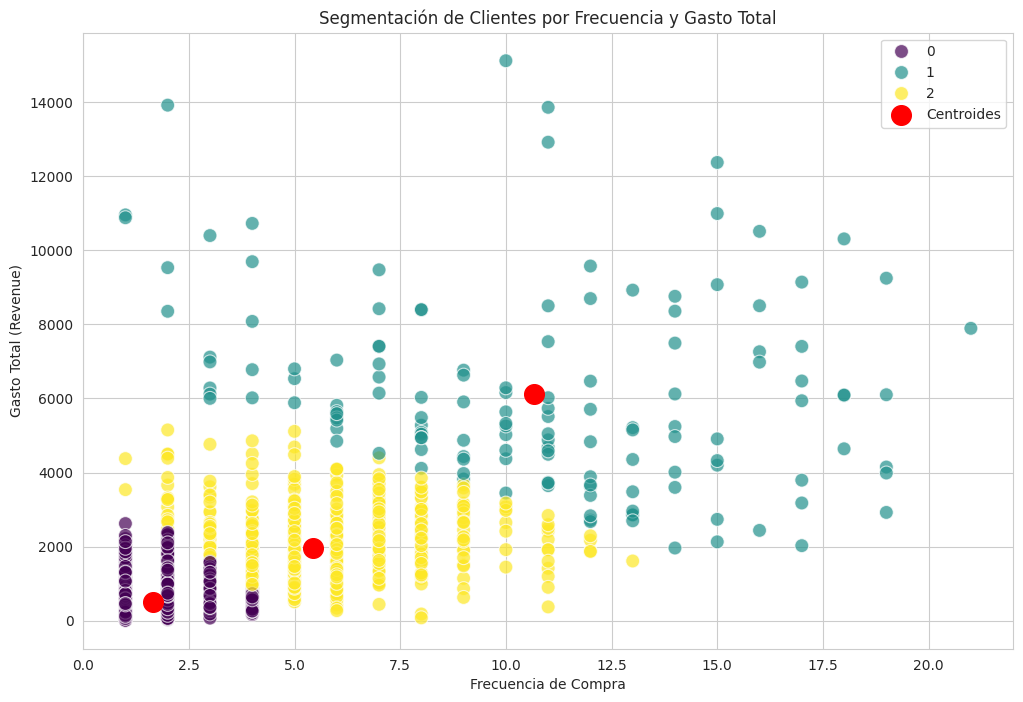

In [38]:
# --- Creación del Modelo K-Means con k=3 ---
optimal_k = 3
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')
kmeans_final.fit(features_scaled_df)

# Añadir las etiquetas de los clusters al DataFrame original (sin escalar)
customer_df_clean['Cluster'] = kmeans_final.labels_

# --- Visualización de los Clusters ---
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=customer_df_clean,
    x='Frequency',
    y='Revenue',
    hue='Cluster',
    palette='viridis',
    s=100, # Tamaño de los puntos
    alpha=0.7 # Transparencia
)

# Obtener los centroides (hay que revertir la estandarización para graficarlos)
centroids = scaler.inverse_transform(kmeans_final.cluster_centers_)

# Graficar los centroides
plt.scatter(centroids[:, 1], centroids[:, 0], s=200, c='red', marker='o', label='Centroides')

plt.title('Segmentación de Clientes por Frecuencia y Gasto Total')
plt.xlabel('Frecuencia de Compra')
plt.ylabel('Gasto Total (Revenue)')
plt.legend()
plt.grid(True)
plt.show()

## Distancia entre los centroides

In [ ]:
# --- Distancia entre puntos ---

dist_matrix = distance_matrix(centroids, centroids)

print(dist_matrix)

[[   0.         5622.70221795 1459.0784243 ]
 [5622.70221795    0.         4163.62477302]
 [1459.0784243  4163.62477302    0.        ]]


## Respuesta a las preguntas y conclusiones

***¿Crees que estos centros puedan ser representativos de los datos? ¿Por qué?***

Si bien los límites están bien definidos, solamente podría considerar un buen grupo el 0 o moraodo ya que las observaciones parte del grupo se aproximan bastante al centroide. Los grupos 2 y 1 carecen de esta característica y por ende son de pero calidad. Otro factor determinante para conocer el rendimiento del modelo es la separación entre grupos. Desafortunadamente los grupos guardan nula separación.

En conclusión no es un modelo tan bueno, sin embargo para fines prácticos es más que suficiente para proponer estrategias de marketing basadas en la calidad de los clientes a los que van dirigidos.

***¿Cómo obtuviste el valor de k a usar?***

Inicialmente teníamos las hipótesis que el número de grupos podría encontrarse entre 2 y 4 debido al objetivo del clustering donde la idea es clasificar los clientes por su valor como cliente, sin embargo para tomar una decisión final usamos el método del codo y concluimos en que un valor de k=3 sería uno óptimo.


***¿Los centros serían más representativos si usaras un valor más alto? ¿Más bajo?***

Al aumentar el valor de k nos arriesgamos a que los grupos no sean significativos y el limite o umbral entre estos sea cada vez más tenue. Al disminuir el valor al mínimo que sería 2, no afectaría mucho al rendimiento del modelo, simplemente cambiaría el enfoque u objetivo del clustering.


***¿Qué distancia tienen los centros entre sí? ¿Hay alguno que este muy cercano a otros?***

La distancia entre el centroide 0 y 2 es: 1459.07

La distancia entre el centroide 0 y 1 es: 5622.7

La distancia entre el centroide 1 y 2 es: 4163.62

Los centroides 0 y 2 son más cercanos en comparación con el 1.

***¿Qué pasaría con los centros si tuviéramos muchos outliers en el análisis de cajas y bigotes?***

Al haber demasiados outliers con valores grandes, la ubicación de los centroides se puede ever afectada ya que estos son sensibles a valores muy altos siendo que la media se encuentra mucho más abajo.


***¿Qué puedes decir de los datos basándose en los centros?***

Cluster 0 (Morado): Frecuencia ≈ 1–2 compras. Gasto total ≈ 500–1000. Representa a clientes poco activos y de bajo valor. Probablemente compran solo una vez o muy ocasionalmente.

Cluster 2 (Amarillo): Frecuencia ≈ 5 compras. Gasto total ≈ 2000. Son clientes de valor medio, visitan ocacionalmente pero sin gastar demasiado. Este grupo podría incrementar su presencia con marketing.

Cluster 1 (Cyan): Frecuencia ≈ 10 compras. Gasto total ≈ 6000. Grupo más importante y frecuentes con un gasto alto. Son los más importantes en los ingresos de la empresa.

